# Galaxy Zoo

<img src="https://raw.githubusercontent.com/illinois-dap/DataAnalysisForPhysicists/main/img/Project_GalaxyZoo-galaxypic.png" width=300 align=left></img><br>

## <span style="color:Orange">Overview</span>

Understanding how and why we are here is one of the fundamental questions for the ages. Part of the answer to this question lies in the origins of galaxies, such as our own Milky Way. Yet questions remain about how the Milky Way (or any of the other ~100 billion galaxies in our Universe) was formed and has evolved. Galaxies come in all shapes, sizes and colors: from beautiful spirals to huge ellipticals. “Kevin Schawinski, previously an astrophysicist at Oxford University and co-founder of Galaxy Zoo, described the problem that led to Galaxy Zoo's creation when he was set the task of classifying the morphology of more than 900,000 galaxies by eye that had been imaged by the Sloan Digital Sky Survey at the Apache Point Observatory in New Mexico, USA.”

## <span style="color:Orange">Data Sources</span>

Original Source
* https://www.kaggle.com/competitions/galaxy-zoo-the-galaxy-challenge/data (requires Kaggle account)

File URLs
* https://courses.physics.illinois.edu/phys503/fa2023/data/projects/GalaxyZoo/all_ones_benchmark.zip
* https://courses.physics.illinois.edu/phys503/fa2023/data/projects/GalaxyZoo/all_zeros_benchmark.zip
* https://courses.physics.illinois.edu/phys503/fa2023/data/projects/GalaxyZoo/central_pixel_benchmark.zip
* https://courses.physics.illinois.edu/phys503/fa2023/data/projects/GalaxyZoo/images_test_rev1.zip
* https://courses.physics.illinois.edu/phys503/fa2023/data/projects/GalaxyZoo/images_training_rev1.zip
* https://courses.physics.illinois.edu/phys503/fa2023/data/projects/GalaxyZoo/training_solutions_rev1.zip

In this project, We are to focused on machine learning application(s).

What is the input data for your Network?

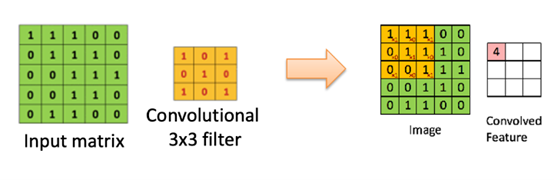

<span style="color:Orange">References</span>

[<span style="color:Red">3</span>] "Feature extraction using convolution", Stanford University, Available: http://deeplearning.stanford.edu/wiki/index.php/Feature_extraction_using_convolution.

**Answer: The input must be an image, which is then transformed into a pixel matrix. Subsequently, we can apply convolution to this pixel matrix using our filter.**

Prepare stage:

In [1]:
import requests
import zipfile
from io import BytesIO
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import requests
import zipfile
from io import BytesIO
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Function to download and extract zip files
def download_and_extract(url, extract_to='.'):
    response = requests.get(url)
    with zipfile.ZipFile(BytesIO(response.content)) as the_zip:
        the_zip.extractall(path=extract_to)

urls = [
    'https://courses.physics.illinois.edu/phys503/fa2023/data/projects/GalaxyZoo/images_training_rev1.zip',
    'https://courses.physics.illinois.edu/phys503/fa2023/data/projects/GalaxyZoo/training_solutions_rev1.zip'
]

for url in urls:
    download_and_extract(url, extract_to='./data')


**Method**

I found reference notebook code on the Kaggle challenge website, provided by one of the competitors. I strictly followed their code, modifying it for simplification. While they classified three classes, I focused on two. Through further exploration and testing of this model, I discovered that it works quite well.

<span style="color:Orange">References Notebook</span>

[<span style="color:Red">2</span>] A. Togni, "Galaxy ConvNet", Kaggle, [2020], Available: https://www.kaggle.com/code/atogni85/galaxy-convnet/notebook.

**Classification**

First, we need figure out the way how we want to classify, then follow the instruction from the notebook[2], we can classfiy class1.1 > 0.7 and class 7.1 > 0.4, which should attribute to eliptical type. Found corresponding image index, shuffle the image, make directory for each type.

Validation dataset image: token from 20 percentage of each type image; then under validation folder, we will see eliptical and spiral folder;
Training dataset image: same reason as before, the rest of 80 percentage image should assign to this folder.

The reason we want to create validation dataset was avoiding overfitting issue when we train our model.

In [2]:
import pandas as pd
import os
import shutil
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_path = './data'
training_solutions_path = os.path.join(base_path, 'training_solutions_rev1.csv')
training_images_path = os.path.join(base_path, 'images_training_rev1')

data_dir = os.path.join(base_path, 'processed_images')

df = pd.read_csv(training_solutions_path)
df.columns = [col.replace('Class', 'Q') for col in df.columns]


ellipticals = df[(df['Q1.1'] > 0.7) & (df['Q7.1'] > 0.4)]['GalaxyID'].tolist()
spirals = df[(df['Q1.2'] > 0.7) & (df['Q2.1'] > 0.4)]['GalaxyID'].tolist()


def _proc_images(src, dst, label, arr, percent):
    train_dir = os.path.join(dst, 'train', label)
    val_dir = os.path.join(dst, 'validation', label)

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    random.shuffle(arr)
    idx = int(len(arr) * percent)
    for i in arr[:idx]:
        shutil.copyfile(os.path.join(src, str(i) + '.jpg'), os.path.join(train_dir, str(i) + '.jpg'))
    for i in arr[idx:]:
        shutil.copyfile(os.path.join(src, str(i) + '.jpg'), os.path.join(val_dir, str(i) + '.jpg'))


src_dir = training_images_path

_proc_images(src_dir, data_dir, 'elliptical', ellipticals, 0.8)
_proc_images(src_dir, data_dir, 'spiral', spirals, 0.8)


Image for sprial galaxy in training dataset.


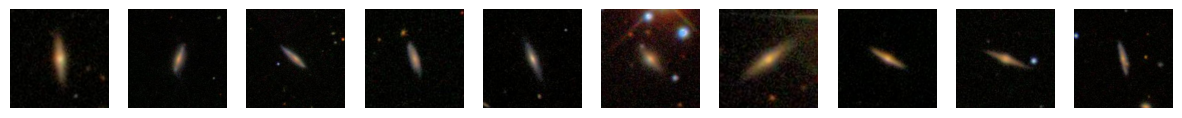

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

def display_elliptical_images(data_dir, num_images=10):
    elliptical_dir = os.path.join(data_dir, 'train', 'spiral')  # Adjust as necessary

    if not os.path.isdir(elliptical_dir):
        print("Directory not found:", elliptical_dir)
        return

    # Get image
    image_files = os.listdir(elliptical_dir)[:num_images]

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for ax, image_file in zip(axes, image_files):
        image_path = os.path.join(elliptical_dir, image_file)
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.axis('off')
    plt.show()


display_elliptical_images(data_dir)


Image for eliptical galaxy in training dataset.


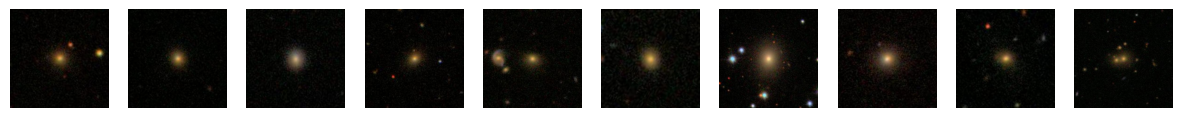

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

def display_elliptical_images(data_dir, num_images=10):
    elliptical_dir = os.path.join(data_dir, 'train', 'elliptical')  # Adjust as necessary

    if not os.path.isdir(elliptical_dir):
        print("Directory not found:", elliptical_dir)
        return

    image_files = os.listdir(elliptical_dir)[:num_images]

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for ax, image_file in zip(axes, image_files):
        image_path = os.path.join(elliptical_dir, image_file)
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

display_elliptical_images(data_dir)


Data Augmentation. Exactly follow the notebook [2]; Rescale, rotate, shift, flip train_dataset image, only rescale validation dataset image.

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=0.2
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(data_dir, 'validation'),
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical'
)


Found 9556 images belonging to 2 classes.
Found 2390 images belonging to 2 classes.


**Galaxy classification architecture**

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Net architecture
model = tf.keras.models.Sequential([
    # first convolution layer, input is an 180x180 image x3 colors
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(180, 180, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # second convolution layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # third convolution layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # fourth convolution layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # flatten the image pixels
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron fully connected hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 20, 20, 128)       0

**Training!!**

In [9]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 5
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)


Epoch 1/5
299/299 [==============================] - 1192s 4s/step - loss: 0.2456 - accuracy: 0.9023 - val_loss: 0.0832 - val_accuracy: 0.9707
Epoch 2/5
299/299 [==============================] - 1172s 4s/step - loss: 0.1196 - accuracy: 0.9607 - val_loss: 0.1003 - val_accuracy: 0.9657
Epoch 3/5
299/299 [==============================] - 1171s 4s/step - loss: 0.1021 - accuracy: 0.9661 - val_loss: 0.0455 - val_accuracy: 0.9849
Epoch 4/5
299/299 [==============================] - 1158s 4s/step - loss: 0.0722 - accuracy: 0.9770 - val_loss: 0.0650 - val_accuracy: 0.9795
Epoch 5/5
299/299 [==============================] - 1156s 4s/step - loss: 0.0655 - accuracy: 0.9789 - val_loss: 0.0414 - val_accuracy: 0.9858


75/75 [==============================] - 77s 1s/step - loss: 0.0414 - accuracy: 0.9858
Validation Loss: 0.041354984045028687
Validation Accuracy: 0.985774040222168


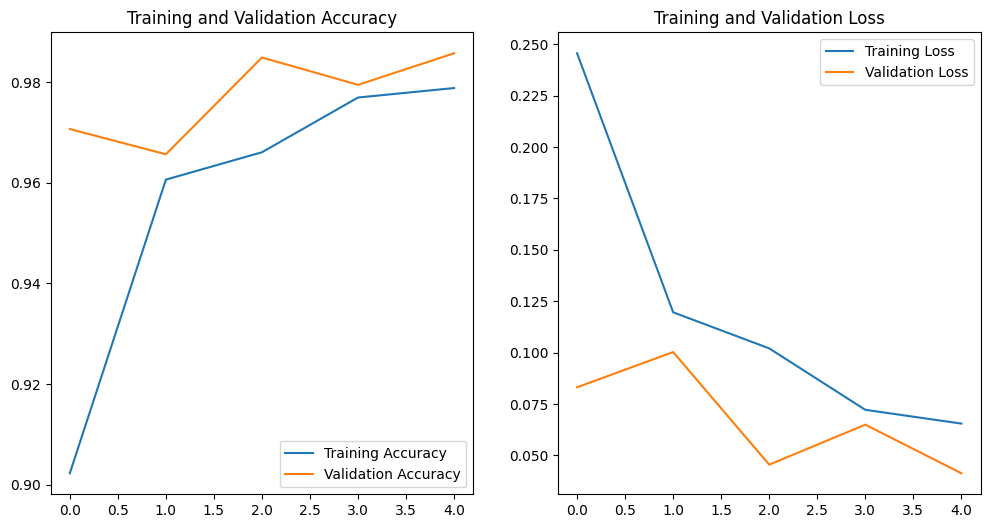

In [10]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Test:

1/1 [==============================] - 0s 50ms/step


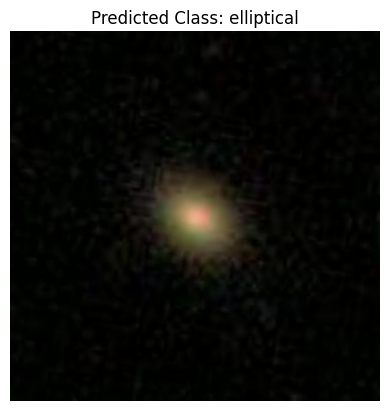

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
from tensorflow.keras.preprocessing import image

# DataFrame
df = pd.read_csv('./data/training_solutions_rev1.csv')
df['GalaxyID'] = df['GalaxyID'].apply(lambda x: f"{x}.jpg")

# Print image
def display_and_predict_random_galaxy(data_dir, model):

    # Random GalaxyID from the DataFrame
    random_image_name = random.choice(df['GalaxyID'].tolist())
    image_path = os.path.join(data_dir, 'images_training_rev1', random_image_name)

    if not os.path.isfile(image_path):
        print("Image file not found:", image_path)
        return

    #rescale (Attribution of our training dataset)
    img = image.load_img(image_path, target_size=(180, 180))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    #prediction
    predictions = model.predict(img_array)
    class_names = ['elliptical', 'spiral']
    predicted_class = class_names[np.argmax(predictions)]

    # Display
    plt.imshow(mpimg.imread(image_path))
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

data_dir = './data'
display_and_predict_random_galaxy(data_dir, model)


1/1 [==============================] - 0s 45ms/step


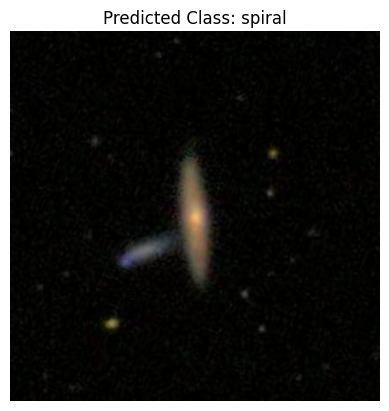

In [12]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

    # Print image
def load_predict_display_galaxy(image_id, data_dir, model):
    image_path = os.path.join(data_dir, 'images_training_rev1', f'{image_id}.jpg')

    if not os.path.isfile(image_path):
        print("Image file not found:", image_path)
        return

    # Rescale
    img = image.load_img(image_path, target_size=(180, 180))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    #prediction
    predictions = model.predict(img_array)
    class_names = ['elliptical', 'spiral']
    predicted_class = class_names[np.argmax(predictions)]

    # Display
    plt.imshow(mpimg.imread(image_path))
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

data_dir = './data'
image_id = '100143'
load_predict_display_galaxy(image_id, data_dir, model)


Input image which is not from training dataset. (It is not follow condition for our Elliptical and spiral classification) I chosen corresponding image index which is class 10.2 (has spiral arm), and its probability is over than 50 percentage. Then it is supposed be spiral image (100813.jpg)

1/1 [==============================] - 0s 215ms/step


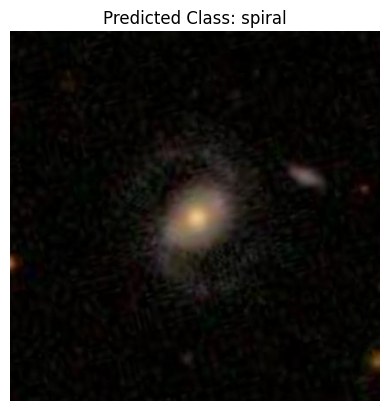

In [78]:
image_id = '100813'
data_dir = './data'

load_predict_display_galaxy(image_id, data_dir, model)

It's hard to believe that it predicted correctly.! Even the spiral is quite blurry to notice.

---

## <span style="color:Orange">References</span>

__[<span style="color:Red">1</span>]__ K.W. Willet, _et.al_, "Galaxy Zoo 2: detailed morphological classifications for 304,122 galaxies from the Sloan Digital Sky Survey", _Mon.Not.Roy.Astron.Soc_. 435 (2013) 2835, e-Print: [1308.3496](https://arxiv.org/abs/1308.3496) [astro-ph.CO]
<span style="color:Orange">References</span>

[<span style="color:Red">2</span>] A. Togni, "Galaxy ConvNet", Kaggle, [2020], Available: https://www.kaggle.com/code/atogni85/galaxy-convnet/notebook.

---

## <span style="color:Orange">Acknowledgements</span>

* Initial version: Mark Neubauer

© Copyright 2023